<a href="https://colab.research.google.com/github/aadityaahire7/ransomware_detection/blob/main/ransomware_detect.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd

dataset = pd.read_csv('/content/ransomware_data.csv')

In [ ]:
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense


In [ ]:
def feature_engineering(dataset):

    # File Complexity:  interaction of sections and stack size
    dataset['FileComplexity'] = dataset['NumberOfSections'] * dataset['SizeOfStackReserve']

    # Version Difference: Difference between OS version and Image version
    dataset['VersionDiff'] = dataset['MajorOSVersion'] - dataset['MajorImageVersion']

    # IsLargeFile: Flag files as large if ResourceSize is above a threshold
    dataset['IsLargeFile'] = np.where(dataset['ResourceSize'] > dataset['ResourceSize'].median(), 1, 0)

    # Debug Data Present: A binary feature if debug size is non-zero
    dataset['DebugDataPresent'] = np.where(dataset['DebugSize'] > 0, 1, 0)

    # Address Size Ratio: Ratio between ExportSize and ExportRVA (if ExportRVA is non-zero)
    dataset['AddressSizeRatio'] = np.where(dataset['ExportRVA'] > 0, dataset['ExportSize'] / dataset['ExportRVA'], 0)

    # adjust outliers : capping SizeOfStackReserve to avoid extreme values
    dataset['SizeOfStackReserve'] = np.where(dataset['SizeOfStackReserve'] > 1e7, 1e7, dataset['SizeOfStackReserve'])

    return dataset




In [ ]:


# Load dataset
dataset = pd.read_csv('/content/ransomware_data.csv')

dataset = feature_engineering(dataset)




In [ ]:
# Handle missing values
dataset.fillna(0, inplace=True)


In [ ]:

# Drop irrelevant columns
X = dataset.drop(['Benign', '`', 'md5Hash'], axis=1)
y = dataset['Benign']



In [ ]:
def remove_highly_correlated_features(dataset, threshold=0.8):
    corr_matrix = dataset.corr()
    upper_triangle = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

    # Find features with correlation greater than the threshold
    to_drop = [column for column in upper_triangle.columns if any(upper_triangle[column].abs() > threshold)]

    print(f"Features to drop due to high correlation: {to_drop}")
    # Drop the highly correlated features
    dataset = dataset.drop(columns=to_drop)

    return dataset

X = remove_highly_correlated_features(X, threshold=0.8)


Features to drop due to high correlation: ['VersionDiff']


In [ ]:
# If any features are categorical, apply encoding
le = LabelEncoder()
for col in X.columns:
    if X[col].dtype == 'object':
        X[col] = le.fit_transform(X[col])



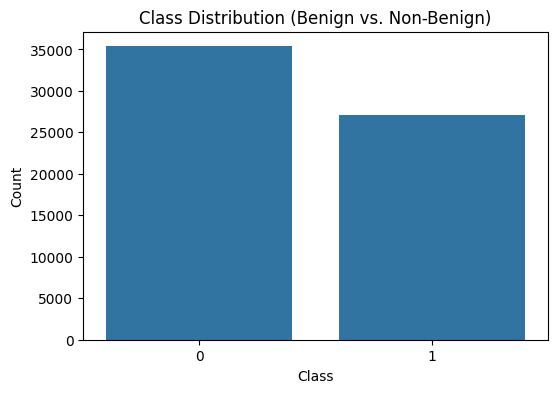

In [ ]:



# 1. Class Distribution Plot
plt.figure(figsize=(6, 4))
sns.countplot(x='Benign', data=dataset)
plt.title('Class Distribution (Benign vs. Non-Benign)')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()





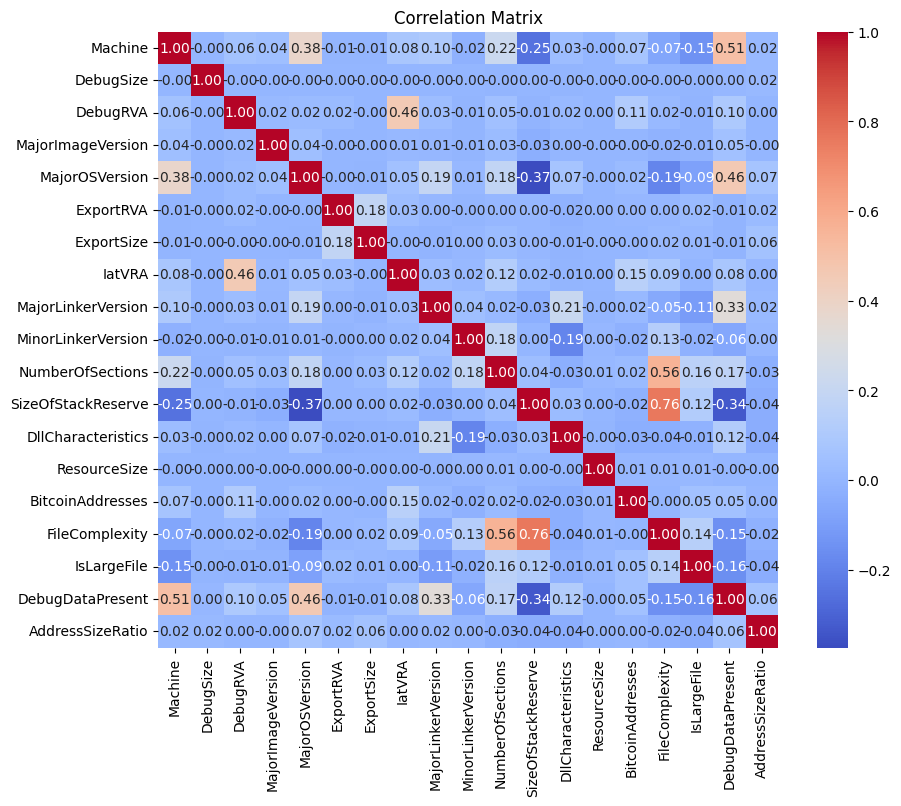

In [ ]:
# Correlation matrix
plt.figure(figsize=(10, 8))
correlation_matrix = X.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Correlation Matrix")
plt.show()


In [ ]:

# Standardizing data before PCA
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

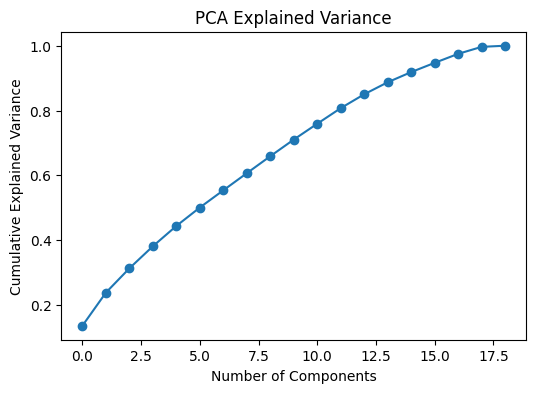

In [ ]:
# 4. PCA Explained Variance Plot
from sklearn.decomposition import PCA
pca = PCA()
pca.fit(X_scaled)
explained_variance = pca.explained_variance_ratio_

plt.figure(figsize=(6, 4))
plt.plot(np.cumsum(explained_variance), marker='o')
plt.title('PCA Explained Variance')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.show()



In [ ]:

# Perform PCA
pca = PCA(n_components=10)
X_pca = pca.fit_transform(X_scaled)
print(f"Explained Variance Ratio by PCA: {pca.explained_variance_ratio_}")

Explained Variance Ratio by PCA: [0.13596949 0.10207848 0.07499849 0.06810835 0.06271702 0.05680485
 0.05316564 0.05276314 0.05245891 0.05134322]


In [ ]:

# Split the dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)




In [ ]:

# Define and train the DNN model using TensorFlow/Keras
def create_dnn_model():
    model = Sequential()
    model.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model




In [ ]:
# Train the DNN model
dnn_model = create_dnn_model()
dnn_model.fit(X_train, y_train, epochs=1, batch_size=32, verbose=1)



/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1563/1563 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.9248 - loss: 0.2339


In [ ]:
# Get predictions from the DNN model
dnn_predictions = dnn_model.predict(X_test)
dnn_predictions = (dnn_predictions > 0.5).astype(int)

391/391 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


In [ ]:

# XGB Classifier
xgb = XGBClassifier(n_estimators=10, max_depth=6, learning_rate=0.1, subsample=0.8, colsample_bytree=0.8,random_state=42)
xgb.fit(X_train, y_train)



XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=10, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [ ]:
# Get predictions from XGB
xgb_predictions = xgb.predict(X_test)

In [ ]:

# Stack the predictions from DNN and XGB
stacked_predictions = np.column_stack((dnn_predictions, xgb_predictions))


In [ ]:

# Train Logistic Regression as the final estimator on the stacked predictions
final_model = LogisticRegression()
final_model.fit(stacked_predictions, y_test)


LogisticRegression()

In [ ]:

# Make final predictions
final_predictions = final_model.predict(stacked_predictions)

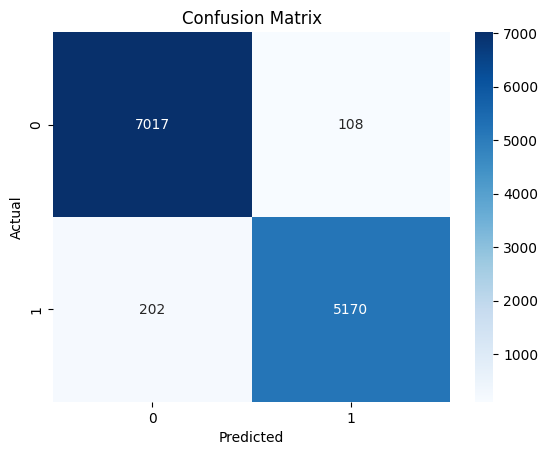

In [ ]:

conf_matrix = confusion_matrix(y_test, final_predictions)

# Confusion Matrix
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()




In [ ]:

# Evaluation metrics
accuracy = accuracy_score(y_test, final_predictions)
precision = precision_score(y_test, final_predictions)
recall = recall_score(y_test, final_predictions)
f1 = f1_score(y_test, final_predictions)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Accuracy: 0.9752
Precision: 0.9795
Recall: 0.9624
F1 Score: 0.9709


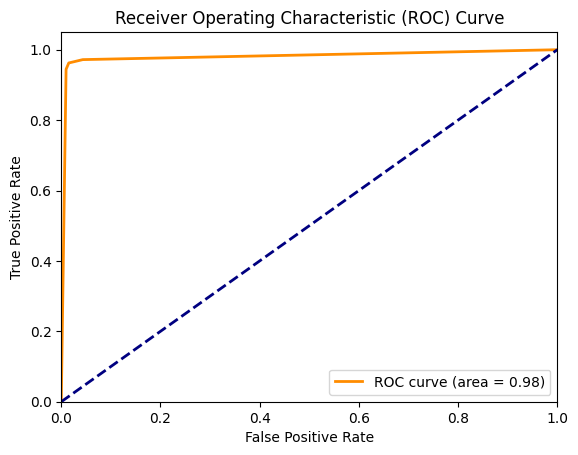

In [ ]:
# ROC Curve
y_pred_proba = final_model.predict_proba(stacked_predictions)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()